In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# Data Prepping
from collections import Counter
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from yellowbrick.classifier import confusion_matrix

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
import statsmodels.discrete.discrete_model as sm

# Scoring the Models
from sklearn import metrics
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    GridSearchCV,
    cross_val_score,
)

# Generating the Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

<IPython.core.display.Javascript object>

In [4]:
import os

# Set spark environments
os.environ[
    "PYTHONPATH"
] = "%SPARK_HOME%\python;%SPARK_HOME%\python\lib\py4j-0.10.7-src.zip:%PYTHONPATH%"

<IPython.core.display.Javascript object>

In [5]:
import findspark

findspark.init("C:/spark/spark-2.4.7-bin-hadoop2.7")

<IPython.core.display.Javascript object>

In [6]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.functions import udf

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
)
from pyspark.mllib.evaluation import MultilabelMetrics

<IPython.core.display.Javascript object>

In [7]:
import pyspark

sc = SparkContext()

<IPython.core.display.Javascript object>

# Establishing Baseline Algorithm Performance. 

## Dataset consists of four (4) profiles:
###  - Fullstack
###  - Database
### -  Machine Learning (ML)
### -  Quality Assurance (QA)

In [8]:
# Open & Read the CSV to PandasDataFrame
four_profiles_Pandas = pd.read_csv("../Logistic_Regression/five_profiles_LogReg.csv")
four_profiles_Pandas.drop(
    [
        "Unnamed: 0",
        "name",
        "profile_standardized",
        "skills_list_x",
        "skills_list",
        "Unnamed: 6",
    ],
    axis=1,
    inplace=True,
)
# Skills can be found on columns[2:-4]
four_profiles_Pandas

,profile,.net,.net 4,.net core,ado.net,afnetworking,api architecture,api design,api development,apis,...,zurb foundation,ios,ios operating system,ipad,jquery,macos.1,database,fullstack,ml,qa
0,Fullstack,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,ML,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,ML,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,QA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,QA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,Database,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
285,Database,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
286,ML,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
287,Database,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


<IPython.core.display.Javascript object>

In [9]:
# Count of Fullstack Developers
four_profiles_Pandas.fullstack.value_counts()

0    197
1     92
Name: fullstack, dtype: int64

<IPython.core.display.Javascript object>

percentage of fullstack developers is 31.83
percentage of non fullstack developers 68.17


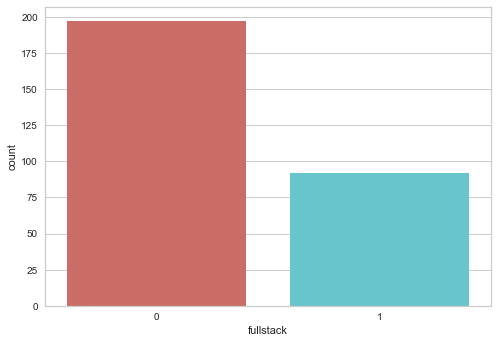

<IPython.core.display.Javascript object>

In [10]:
# Show Class Imbalance
sns.countplot(x="fullstack", data=four_profiles_Pandas, palette="hls")
print(
    "percentage of fullstack developers is",
    "{:.2f}".format(
        len(four_profiles_Pandas[four_profiles_Pandas["profile"] == "Fullstack"])
        / len(four_profiles_Pandas)
        * 100
    ),
)
print(
    "percentage of non fullstack developers",
    "{:.2f}".format(
        (
            len(four_profiles_Pandas)
            - len(four_profiles_Pandas[four_profiles_Pandas["profile"] == "Fullstack"])
        )
        / len(four_profiles_Pandas)
        * 100,
    ),
)
# Plot will show roughly a 70:30 ratio of non-fullstack to fullstack developers
plt.show()

In [11]:
# Assign data to X and y
X = four_profiles_Pandas.iloc[:, 1:-4]
xSkillsCols = X

y = four_profiles_Pandas.iloc[:, -3]

<IPython.core.display.Javascript object>

In [12]:
# Split to training and testing sets
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=0)

<IPython.core.display.Javascript object>

In [13]:
# Generate sklearn LogisticRegression model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

<IPython.core.display.Javascript object>

In [14]:
# Establishing Baseline/Benchmark
y_pred = logreg.predict(X_test)
print(
    "Accuracy of logistic regression classifier on test set: {:.2f}".format(
        logreg.score(X_test, y_test)
    )
)

Accuracy of logistic regression classifier on test set: 0.89


<IPython.core.display.Javascript object>

[[54  2]
 [ 8 23]]


<AxesSubplot:>

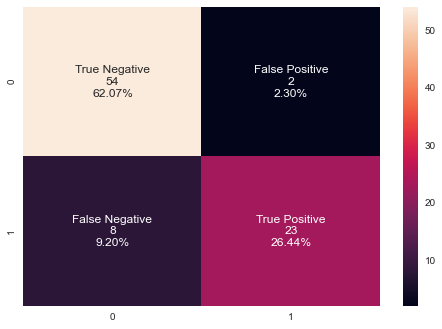

<IPython.core.display.Javascript object>

In [15]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

group_names = ["True Negative", "False Positive", "False Negative", "True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
labels = [
    f"{v1}\n{v2}\n{v3}"
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cm, annot=labels, fmt="")

This shows that only about 11% of profiles are being incorrectly classified as False Positives and False Negatives. To yield better algorithm performance, we'll engage in a Feature Selection method known as Recursive Feature Selection.

# Improving Algorithm Performance : Recursive Feature Elimination (RFE)

In [16]:
# Generates RFE model
rfe = RFE(logreg)
# Fits the model
rfe = rfe.fit(X, y)
# Returns bool arr of True for features_selected
mask = rfe.support_
# Rank of 1 indicates features selected
print(rfe.ranking_)

[  1 132   1 126   1   1   1 164 160 123  94  32   1   1  16  38   1  15
   7   1   1   1   1  82   1  85  50   1   1 113  39   1   1 146 110  33
   1   1   1   1   1   6 133 125   1   1   1 103   1 108   1  74   1   4
   3 169   1   1   1  80  45   1   1   1   1  51   1 161   1  47 154   5
   1   1   1   1   1  76   1   2 156  91 134   1   1 127   1   1   1  95
  49  83   1  99   1  78 111   1   1  31  48   1  46  27   1 147   1   1
   8   1   1 158   1   1  34 150  65   1   1 100  25 142   1   1 162 163
 145   1   9  86   1  70  20 120  35  28  98  67 166   1 116  21 135   1
   1   1  29   1   1   1   1   1  14 119 152   1  42   1   1   1   1   1
 165 130  26 107   1   1   1   1  53 117   1   1 144   1  19  57  81 167
   1   1   1   1   1  30   1  96  66 143   1  79  97   1   1  24 129 102
  10 105 159   1  60 106   1 109   1 149  92  18   1   1   1   1 141 124
   1   1  69   1   1   1   1   1  75  72   1   1 118  41 112  58  55   1
   1  22 115 153 139 122  56   1 104  54   1   1   

<IPython.core.display.Javascript object>

In [17]:
# Masking for Selected Features returned by RFE
selected_cols = xSkillsCols.columns[mask]

<IPython.core.display.Javascript object>

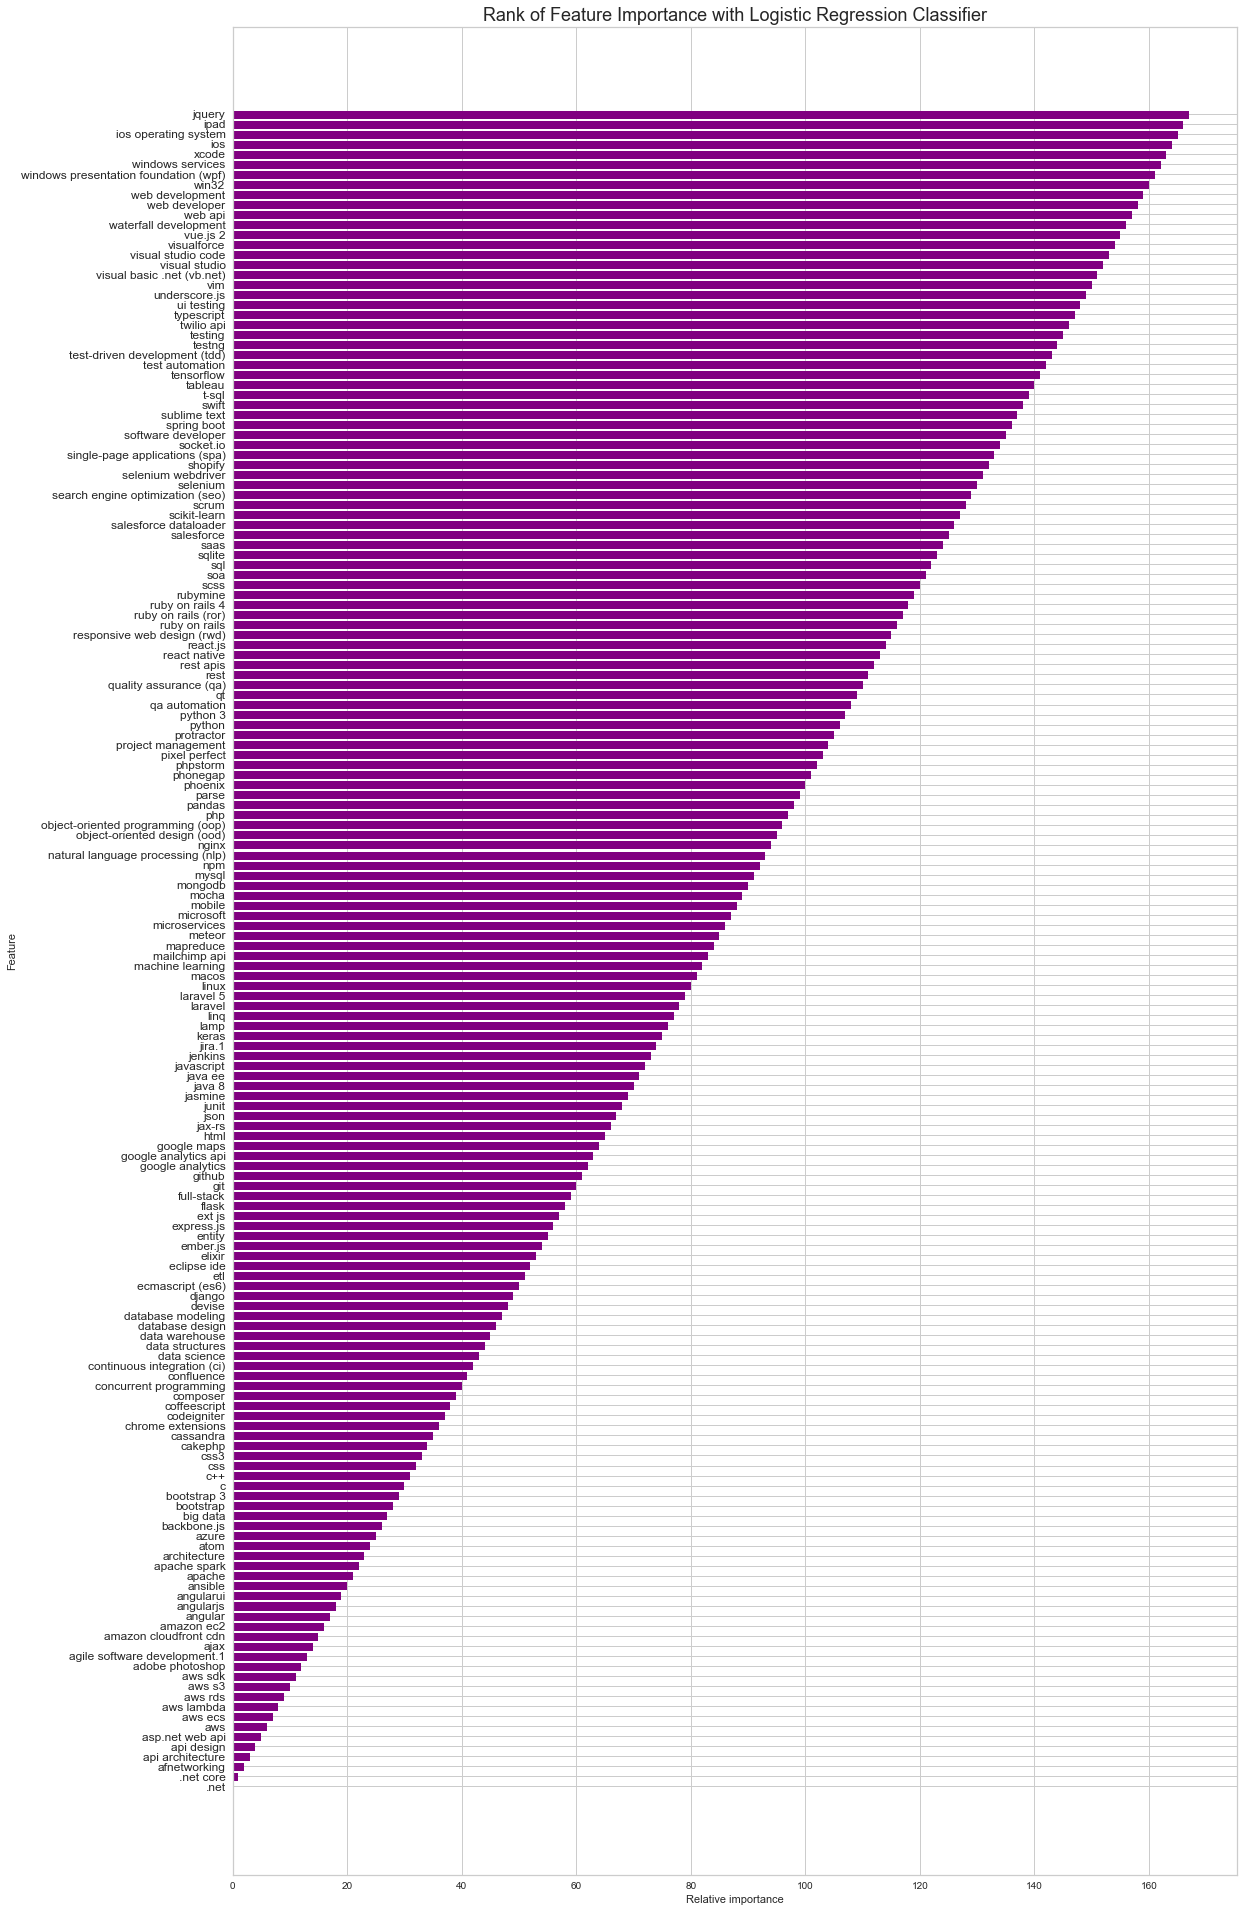

<Figure size 576x1728 with 0 Axes>

<IPython.core.display.Javascript object>

In [18]:
# Display Features Selected
col = selected_cols
y_axis = np.arange(0, len(selected_cols))

fig, ax = plt.subplots()
width = 0.8  # the width of the bars
ind = np.arange(len(y_axis))  # the x locations for the groups
ax.barh(ind, y_axis, width, color="purple")
ax.set_yticks(ind + width / 10)
ax.set_yticklabels(col, fontsize=12, rotation=0, minor=False)
plt.title("Rank of Feature Importance with Logistic Regression Classifier", fontsize=18)
plt.xlabel("Relative importance")
plt.ylabel("Feature")
plt.figure(figsize=(8, 24))
fig.set_size_inches(18, 34, forward=True)

# We'll now re-test our algorithm to understand whether applying RFE to our dataset improved algorithm performance

In [19]:
# Assigning newly reduced data to X
X = four_profiles_Pandas[selected_cols]

<IPython.core.display.Javascript object>

In [20]:
# Again, splitting to training and testing sets
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=0)

<IPython.core.display.Javascript object>

In [21]:
# Generate sklearn LogisticRegression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

<IPython.core.display.Javascript object>

In [22]:
# Scoring the algorithm's performance using the newly reduced dataset
y_pred = logreg.predict(X_test)
print(
    "Accuracy of logistic regression classifier on test set: {:.2f}".format(
        logreg.score(X_test, y_test)
    )
)

Accuracy of logistic regression classifier on test set: 0.92


<IPython.core.display.Javascript object>

## Interpreting the Results: It appears that eliminating those features of least importance to predicting the target class did improve algorithm performance. Model now predicts 92% accuracy earlier when it made predictions with 89% accuracy.

# Implementing Logistic Regression with PySpark
Data will first be read from Pandas DataFrame to Spark DataFrame.

In [23]:
# Set up PySpark
conf = SparkConf()
conf.setMaster("local")
conf.setAppName("AppName")
sqlCtx = SQLContext(sc)

<IPython.core.display.Javascript object>

In [24]:
# Create Spark DataFrame (sdf)
sdf = sqlCtx.createDataFrame(four_profiles_Pandas)

<IPython.core.display.Javascript object>

In [25]:
# Test to ensure only skills lie on the sdf's columns -- should return False
"profile" in selected_cols

False

<IPython.core.display.Javascript object>

In [26]:
# Build a Dict to Map: (orginal column name: new column name)
mapping = {col: col.replace(".", "_").replace(" ", "_") for col in selected_cols}

<IPython.core.display.Javascript object>

In [27]:
# Test to ensure number of cols in mapping = number of skills in Pandas DataFrame -- should = 168
len(mapping.values())

168

<IPython.core.display.Javascript object>

In [28]:
# Select all columns and create an alias if there is a mapping for this column
df_renamed = sdf.select(
    [F.col("`" + c + "`").alias(mapping.get(c, c)) for c in sdf.columns]
)

<IPython.core.display.Javascript object>

In [29]:
# Create a VectorAssembler obj that takes the renamed columns as input
assembler = VectorAssembler(inputCols=list(mapping.values()), outputCol="features")
transformed_data = assembler.transform(df_renamed)

<IPython.core.display.Javascript object>

In [30]:
# Rename the Fullstack column to label
data = transformed_data.withColumnRenamed("fullstack", "label")

<IPython.core.display.Javascript object>

# Handling class imbalance using PySpark
1) Dataset contains 36.04 % negatives and 63.96 % positives. Because positives make up the majority of the dataset, the logistic loss objective function should treat the negative class (Outcome == 0) with higher weight. Therefore, the BalancingRatio is calculated as follows:

In [31]:
numPositives = 92
dataset_size = 289
BalancingRatio = numPositives / dataset_size
print("BalancingRatio = {}".format(BalancingRatio))

BalancingRatio = 0.31833910034602075


<IPython.core.display.Javascript object>

2) Against every Outcome == 0, BalancingRatio is applied to column “classWeights”. Against every Outcome == 1, 1-BalancingRatio is applied to column “classWeights”.

In [32]:
data = data.withColumn(
    "classWeights",
    F.when(data.label == 0, BalancingRatio).otherwise(1 - BalancingRatio),
)

<IPython.core.display.Javascript object>

In [33]:
# Split to training and testing sets
# DID .8 to .2 yield better results?
(train, test) = data.randomSplit([0.7, 0.3])

<IPython.core.display.Javascript object>

# We'll now re-test our algorithm to understand whether applying methods to correct for Class Imbalance further improved algorithm performance

In [34]:
from pyspark.ml.classification import LogisticRegression

# Create Logistic Regression PySpark Model
lr = LogisticRegression(
    featuresCol="features", labelCol="label", weightCol="classWeights", maxIter=100
)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary

<IPython.core.display.Javascript object>

In [35]:
# Generate Presdictions
lr_predictions = lrModel.transform(test)
lr_predictions.select("label", "prediction").show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows



<IPython.core.display.Javascript object>

# ROC is a plot of the TPR (Recall)  on the y-axis, vs. the FPR on the x-axis
TPR = (Recall = Sensitivity) = True Positive / Actual Positive (TP + FN)
FPR is like the opposite of (Precision = Specificity) = (1 - Specificity) = FP / (TN + FP)
Specificty / Precision = TN / TN + FP
### An ROC (probability) Curve goes beyond a single misclassification rate (error for single threshold), and visualizes all possible thresholds.
Sensitivity & Specificity are inversely proportional to each other.

# AUC (area under the curve) tells us how good the model is at distinguishing between classes (Predicting 0's as 0's and 1's as 1's). 
A good AUC model is close to 1. This indicates it has a good measure of separability.
An AUC value equal to 0.7 would indicate a 70% chance of the model correctly classifying a positive or negative class.
An AUC value of approximately 0.5 would indicate that the model is inable to discriminate between the positive and the negative class.

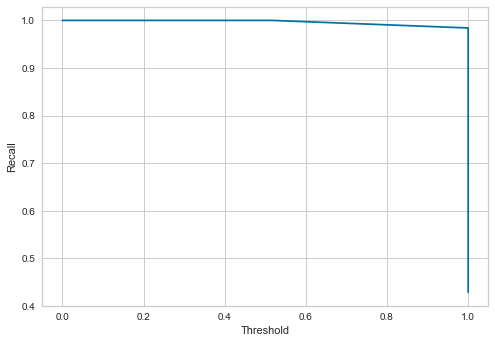

<IPython.core.display.Javascript object>

In [37]:
# Plot the threshold-recall curve
tr = trainingSummary.recallByThreshold.toPandas()
plt.plot(tr["threshold"], tr["recall"])
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.show()

In [ ]:
# Plot the threshold-precision curve
tp = trainingSummary.precisionByThreshold.toPandas()
plt.plot(tp["threshold"], tp["precision"])
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.show()

## Indication of High-Performing Model: 
The following ROC Curve indicates the model has ideal measure of separability and is able to distinguish between positive and negative classes.
## Indication of Poorly-Performing Model:
An ROC curve indicating a model not able to distinguish between positive and negative clasess would flatten to a diagonal line. This would indicate presence of Type 1 and 2 errors.

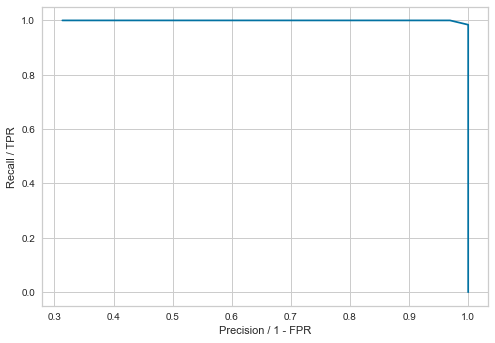

<IPython.core.display.Javascript object>

In [39]:
# Plot the recall-precision curve
pr = trainingSummary.pr.toPandas()
plt.plot(pr["precision"], pr["recall"])
plt.xlabel("Precision / 1 - FPR")
plt.ylabel("Recall / TPR")
plt.show()

@TODO
# Finally, we can additionally tune the hyperparameters of our algorithm to boost algorithm performance ever more. Hyperparameters include...Explain regParam, elasticNetParam, maxIter
.addGrid(lr.regParam, [0.01, 0.5, 2.0])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .addGrid(lr.maxIter, [1, 5, 10])
# by implementing numFolds = 5, we create a more robust test which returns more reliable results of the algorithm's actual performance

In [40]:
evaluator = BinaryClassificationEvaluator(metricName="areaUnderPR")
# Create ParamGrid for Cross Validation
paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.5, 2.0])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .addGrid(lr.maxIter, [1, 5, 10])
    .build()
)

cv = CrossValidator(
    estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5
)

# Run cross validations
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
predictions_pandas = predictions.toPandas()
print(
    "Test Area Under PR: ", evaluator.evaluate(predictions)
)  # Calculate and print f1, recall and precision scores
f1 = f1_score(predictions_pandas.label, predictions_pandas.prediction)
recall = recall_score(predictions_pandas.label, predictions_pandas.prediction)
precision = precision_score(predictions_pandas.label, predictions_pandas.prediction)
# IS THE TEST AREA UNDER PR THE NUMBER YOU'D WANT TO USE TO COMPARE???
print("F1-Score: {}, Recall: {}, Precision: {}".format(f1, recall, precision))

Test Area Under PR:  0.9582076124726778
F1-Score: 0.8813559322033899, Recall: 0.896551724137931, Precision: 0.8666666666666667


<IPython.core.display.Javascript object>

# Multinomial Logsitc Regression in PySpark with RFE

In [44]:
def udf_multiple(profile):
    if profile == "Database":
        return 1
    elif profile == "Fullstack":
        return 2
    elif profile == "ML":
        return 3
    elif profile == "QA":
        return 4
    else:
        return "N/A"

<IPython.core.display.Javascript object>

In [45]:
profile_udf = udf(udf_multiple)
data = data.withColumn("outcome", profile_udf("profile"))

AttributeError: 'DataFrame' object has no attribute 'withColumn'

<IPython.core.display.Javascript object>

In [ ]:
changedTypedf = data.withColumn("label", data["outcome"].cast(DoubleType()))

In [ ]:
# Split the data
(train, test) = changedTypedf.randomSplit([0.7,0.3])

In [ ]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', family="multinomial")
lrModel = lr.fit(train)

In [ ]:
lr_predictions = lrModel.transform(test)
lr_predictions.select("label","prediction").show(25)

In [ ]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'label', metricName = 'accuracy')
print('Logistic Regression Accuracy:', multi_evaluator.evaluate(lr_predictions))